## Projeto 3 - Machine Learning

Caio Emanuel Rhoden - RA 214129

Aqui temos a tentativa de criação de um programa genético para tentar fazer a criação de um pacman que consiga 

In [1]:
from pacman2 import runGames,readCommand
from game import Agent, Directions
from util import manhattanDistance, PriorityQueue
import random
import statistics
import matplotlib.pyplot as plt

### Sumário

### Cromossomo

O cromossomo representa boa aprte da ideia por tràs do nosso Algoritmo Genético, ele é formado por um dicionário que possui uma lista para 'order', que prioriza as possiveis situações para o individuo:
- Ter comdia adjascente
- Ter comida próxima mas não adjascente
- Estar dentro de uma "zona de perigo"

Cada uma das outras keys representam uma PriorityQueue, estrutura de dados que permite adicionar um elemnto com base em seu valor e prioridade, quanto menor a prioridade antes o elemento é retornado. Os valores representam as direções:
- 0: WEST
- 1: NORTH
- 2: EAST
- 3: SOUTH

As prioridades representam a ordem das  direções o pacman vai tomar dentro das disponiveis

In [2]:
def create_random_chromossome():

    chromossome = {
        'order': random.sample([i for i in range(1, 10)], 3),
        
        #adjascent food at north
        'food_north': PriorityQueue(),
        
        #adjascent food at west
        'food_west': PriorityQueue(),
        
        #adjascent food at east
        'food_east': PriorityQueue(),
        
        #adjascent food at south
        'food_south': PriorityQueue(),
        
        #food at south - ghost in same x and higher y
        'near_food_1': PriorityQueue(),

        #food at south and east - ghost in higher x and higher y
        'near_food_2': PriorityQueue(),

        #food at from east, - ghost higher x and same y
        'near_food_3': PriorityQueue(),

        #food at north east - ghost higher x and lower y
        'near_food_4':PriorityQueue(),

        #food at north - ghost at same x and lower y
        'near_food_5':PriorityQueue(),

        #food at north and west - ghost lower x and lower y
        'near_food_6': PriorityQueue(),

        #food at west - ghost lower x and same y
        'near_food_7':PriorityQueue(),

        #food at south and west - ghost lower x and higher y
        'near_food_8': PriorityQueue(),
        
#         'near_capsule_1': PriorityQueue(),

#         #food at south and east - ghost in higher x and higher y
#         'near_capsule_2': PriorityQueue(),

#         #food at from east, - ghost higher x and same y
#         'near_capsule_3': PriorityQueue(),

#         #food at north east - ghost higher x and lower y
#         'near_capsule_4':PriorityQueue(),

#         #food at north - ghost at same x and lower y
#         'near_capsule_5':PriorityQueue(),

#         #food at north and west - ghost lower x and lower y
#         'near_capsule_6': PriorityQueue(),

#         #food at west - ghost lower x and same y
#         'near_capsule_7':PriorityQueue(),

#         #food at south and west - ghost lower x and higher y
#         'near_capsule_8': PriorityQueue(),

        #enemy coming from south - ghost in same x and higher y
        'danger_1': PriorityQueue(),

        #enemy coming from south and east - ghost in higher x and higher y
        'danger_2': PriorityQueue(),

        #enemy coming from east, - ghost higher x and same y
        'danger_3': PriorityQueue(),

        #enemy coming from north east - ghost higher x and lower y
        'danger_4':PriorityQueue(),

        #enemy coming from north - ghost at same x and lower y
        'danger_5':PriorityQueue(),

        #enemy coming from north and west - ghost lower x and lower y
        'danger_6': PriorityQueue(),

        #enemy coming from west - ghost lower x and same y
        'danger_7':PriorityQueue(),

        #enemy coming from south and west - ghost lower x and higher y
        'danger_8': PriorityQueue()

    }
    
    for i in range(1,21):
        values = [0, 1, 2, 3]
        random.shuffle(values)
        priorities = [0, 1, 2, 3]
        random.shuffle(priorities)

        chromossome[list(chromossome.keys())[i]].push(values[0], priorities[0])
        chromossome[list(chromossome.keys())[i]].push(values[1], priorities[1])
        chromossome[list(chromossome.keys())[i]].push(values[2], priorities[2])
        chromossome[list(chromossome.keys())[i]].push(values[2], priorities[3])

        
    
    return chromossome

In [3]:
a = create_random_chromossome()['order']
print(a)
a = create_random_chromossome()['near_food_1']
print(a.heap)
print(a.pop())
print(a.heap)
print(a.pop())
print(a.heap)
print(a.pop())
print(a.heap)

[2, 3, 8]
[(0, 3, 0), (1, 0, 2), (3, 2, 0), (2, 1, 1)]
0
[(1, 0, 2), (2, 1, 1), (3, 2, 0)]
2
[(2, 1, 1), (3, 2, 0)]
1
[(3, 2, 0)]


### Agente

In [4]:
## Define some rules for the pacman agent

class SingleLookAgent(Agent):
    
    ## Recevies the chromosome, the danger distance from ghosts and initialize de total food of the maze
    
    def __init__(self, dist, chromo, index=0):
        super().__init__(index)
        self.chromossome = chromo
        self.dist = dist
        self.foodTotal = 0
        self.order = self.chromossome['order'].copy()
    
    ## Methods that will give the directions for the pacmna
    def goWest(self):
        return 'West'
    def goNorth(self):
        return 'North'
    def goEast(self):
        return 'East'
    def goSouth(self):
        return 'South'
    
    ## Based in the method received the PriorityQueue is retrieved from the chromosomes, and based in the 
    ## legal actions is selected the direction for the agente to follow
    def getActionfromQueue(self, state, mode):
        #print(mode)
        if state.getNumFood() > self.foodTotal:
            self.foodTotal = state.getNumFood()
        
        actionsPushed = []
        found = False
        
        actionsList = ['WEST', 'NORTH', 'EAST', 'SOUTH']
        
        actionsDict = {
            'WEST': self.goWest(),
            'NORTH': self.goNorth(),
            'EAST': self.goEast(),
            'SOUTH': self.goSouth()
        }
        while not found and len((self.chromossome[mode].heap)) > 0:
            actionsPushed.append(self.chromossome[mode].pop())
            action = actionsDict[actionsList[actionsPushed[-1]]]
            if action in  state.getLegalPacmanActions() and action != 'Stop':
                found = True
        for i in range(len(actionsPushed)):
            self.chromossome[mode].push(actionsPushed[i], i)
        if found:
            #print(action)
            return action
        else:
            return state.getLegalPacmanActions()[random.randrange(len(state.getLegalPacmanActions()))]
    
    def getAdjascentActions(self, state, pacman_pos):
        
        west = [pacman_pos[0]-1, pacman_pos[1], self.getActionfromQueue(state, 'food_west'), 'west']
        east = [pacman_pos[0]+1, pacman_pos[1], self.getActionfromQueue(state, 'food_east'), 'east']
        north = [pacman_pos[0], pacman_pos[1]+1, self.getActionfromQueue(state, 'food_north'), 'north']
        south = [pacman_pos[0], pacman_pos[1]-1, self.getActionfromQueue(state, 'food_south'), 'south']
        possibleAdjascentes = random.sample([west, east, north, south], 4)
        
        for i in possibleAdjascentes:
            if state.hasFood(i[0], i[1]):
                self.order = self.chromossome['order'].copy()
                return i[2]
        
        return(self.getAction(state))
    
    def getNearCapsuleActions(self, state, pacman_pos):
        
        dists = [manhattanDistance(pacman_pos , i) for i in state.getCapsules()]
        positions = [i for i in state.getCapsules()]
        if len(positions) > 0:
            near_food = positions[dists.index(min(dists))]
            if pacman_pos[0] == near_food[0] and pacman_pos[1] < near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_1')

            elif pacman_pos[0] < near_food[0] and pacman_pos[1] < near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_2')

            elif pacman_pos[0] < near_food[0] and pacman_pos[1] == near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_3')

            elif pacman_pos[0] < near_food[0] and pacman_pos[1] > near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_4')

            elif pacman_pos[0] == near_food[0] and pacman_pos[1] > near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_5')

            elif pacman_pos[0] > near_food[0] and pacman_pos[1] > near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_6')

            elif pacman_pos[0] > near_food[0] and pacman_pos[1] == near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_7')

            elif pacman_pos[0] > near_food[0] and pacman_pos[1] < near_food[1]:
                self.order = self.chromossome['order'].copy()
                return self.getActionfromQueue(state, 'near_capsule_8')
            else:
                return(self.getAction(state))
        
    def getNearFoodActions(self, state, pacman_pos):
        
        foodDistances = [manhattanDistance(pacman_pos , foodPos) for foodPos in state.getFood().asList()]
        minDist = min(foodDistances)
        minIndices = [i for i, x in enumerate(foodDistances) if x == minDist]
        near_food = state.getFood().asList()[minIndices[random.randrange(len(minIndices))]]
        if pacman_pos[0] == near_food[0] and pacman_pos[1] < near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_1')

        elif pacman_pos[0] < near_food[0] and pacman_pos[1] < near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_2')

        elif pacman_pos[0] < near_food[0] and pacman_pos[1] == near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_3')

        elif pacman_pos[0] < near_food[0] and pacman_pos[1] > near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_4')

        elif pacman_pos[0] == near_food[0] and pacman_pos[1] > near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_5')

        elif pacman_pos[0] > near_food[0] and pacman_pos[1] > near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_6')

        elif pacman_pos[0] > near_food[0] and pacman_pos[1] == near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_7')

        elif pacman_pos[0] > near_food[0] and pacman_pos[1] < near_food[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'near_food_8')
        else:
            return(self.getAction(state))
    
    def getDangerActions(self, state, pacman_pos):
        
        dist_ghosts = [(manhattanDistance(pacman_pos , state.getGhostPosition(1)), state.getGhostPosition(1)),
                       (manhattanDistance(pacman_pos , state.getGhostPosition(2)),state.getGhostPosition(2))]
        random.shuffle(dist_ghosts)
        
        if dist_ghosts[0][0] <= dist_ghosts[1][0]:
            near_dist = dist_ghosts[0][0]
            near_ghost = dist_ghosts[0][1]
        else:
            near_dist = dist_ghosts[1][0]
            near_ghost = dist_ghosts[1][1]
        
        if pacman_pos[0] == near_ghost[0] and pacman_pos[1] < near_ghost[1]:
            self.order = self.chromossome['order'].copy() 
            return self.getActionfromQueue(state, 'danger_1')

        elif pacman_pos[0] < near_ghost[0] and pacman_pos[1] < near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_2')

        elif pacman_pos[0] < near_ghost[0] and pacman_pos[1] == near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_3')

        elif pacman_pos[0] < near_ghost[0] and pacman_pos[1] > near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_4')

        elif pacman_pos[0] == near_ghost[0] and pacman_pos[1] > near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_5')

        elif pacman_pos[0] > near_ghost[0] and pacman_pos[1] > near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_6')

        elif pacman_pos[0] > near_ghost[0] and pacman_pos[1] == near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_7')

        elif pacman_pos[0] > near_ghost[0] and pacman_pos[1] < near_ghost[1]:
            self.order = self.chromossome['order'].copy()
            return self.getActionfromQueue(state, 'danger_8')
        else:
            return(self.geAction(state))
        
        

    def getAction(self, state):
        pacman_pos = state.getPacmanPosition()
        current = state.getPacmanState().configuration.direction
        #defines random init between legal actions
        if current == 'Stop':
            sub_action = state.getLegalPacmanActions()[random.randrange(len(state.getLegalPacmanActions()))]
            while sub_action == 'Stop':
                sub_action = state.getLegalPacmanActions()[random.randrange(len(state.getLegalPacmanActions()))]
            return sub_action
        
        while max(self.order) > 0:
            choosen_index = self.order.index(max(self.order)) 
            if self.order[choosen_index] > 0:
                self.order[choosen_index] = 0
                
                if choosen_index == 0:
                    return self.getAdjascentActions(state, pacman_pos)
                
#                 elif choosen_index == 1:
#                     return self.getNearCapsuleActions(state, pacman_pos)
            
                if choosen_index == 1:
                    return self.getNearFoodActions(state, pacman_pos)
                
                else:
                    return self.getDangerActions(state, pacman_pos)
        print('nothing found')
        self.order = self.chromossome['order'].copy()
        sub_action = state.getLegalPacmanActions()[random.randrange(len(state.getLegalPacmanActions()))]
        while sub_action == 'Stop':
            sub_action = state.getLegalPacmanActions()[random.randrange(len(state.getLegalPacmanActions()))]
        return sub_action

    

In [5]:

agente = SingleLookAgent(1, create_random_chromossome())
args = readCommand(['-q', '--pacman', 'GreedyAgent', '-l', 'smallClassic','-n', '1'])
args['pacman'] = agente
a = runGames(**args)
print(args['pacman'].foodTotal)
print(a)


54


In [6]:
print(a[0].state.isWin())

False


### Initiate Random Population

In [7]:
def randomPopulation(size):
    population = []
    for i in range(size):
        population.append(create_random_chromossome())
        
    return population

In [8]:
randomPopulation(2)

[{'order': [6, 8, 9],
  'food_north': <util.PriorityQueue at 0x21c0b9cabe0>,
  'food_west': <util.PriorityQueue at 0x21c0b9caa60>,
  'food_east': <util.PriorityQueue at 0x21c0b9ca220>,
  'food_south': <util.PriorityQueue at 0x21c0dbdcfa0>,
  'near_food_1': <util.PriorityQueue at 0x21c0b9a0fa0>,
  'near_food_2': <util.PriorityQueue at 0x21c0c23c430>,
  'near_food_3': <util.PriorityQueue at 0x21c0d5d3fd0>,
  'near_food_4': <util.PriorityQueue at 0x21c0d5d3d90>,
  'near_food_5': <util.PriorityQueue at 0x21c0b9cf460>,
  'near_food_6': <util.PriorityQueue at 0x21c0b9cf220>,
  'near_food_7': <util.PriorityQueue at 0x21c0b9cfd00>,
  'near_food_8': <util.PriorityQueue at 0x21c0b9cf2e0>,
  'danger_1': <util.PriorityQueue at 0x21c0b9cfc40>,
  'danger_2': <util.PriorityQueue at 0x21c0b9cfb80>,
  'danger_3': <util.PriorityQueue at 0x21c0b9cfe20>,
  'danger_4': <util.PriorityQueue at 0x21c0b9cf5e0>,
  'danger_5': <util.PriorityQueue at 0x21c0dbe7610>,
  'danger_6': <util.PriorityQueue at 0x21c0dbe7

### Fitness Function

Aqui vamos estabelecer como condição de sucesso para os individuos, inicialmente podemos estabelecer como critério de sucesso a vitória para os tabuleiros, e para avaliar a aptidão dos individuos até lá, a pontuação total obtida. A ideia inicial era fazer  a aptidão a partir do número de comidas que o nosso agente consumiu, no entando por não conseguir extrair essa informação da engine foi mantido o score médio dos jogos

In [9]:
def fitnessFunction(gamesResult, totalFood):
    gamesScores = [(totalFood - i.state.getNumFood() + 1) for i in gamesResult]
    avgScore = statistics.mean(gamesScores)            
    return(avgScore)

### Seleção

Para seleção aplicaremos o método de campeonado em que faremos n campeonatos, dependendo do número de individuos que queremos selecionar, e para cada campeonato pegaremos um número aleatorio de individuos, e dentre esses selecionaremos o com o maior fitness score para ser um dos sortudos que vão passar para a próxima geração

In [10]:
def selection(layout, population, n, dist, n_games):
    selected = []
    popScores = []
    for i in range(len(population)):
        agente =  SingleLookAgent(dist, population[i])
        args = readCommand(['-q', '--pacman', 'Agent', '-g', 'DirectionalGhost','-l', layout,'-n', str(n_games)])
        args['pacman'] = agente
        popScores.append(runGames(**args))
    acumulatedScores = []
    fitnessScores = [fitnessFunction(i, args['pacman'].foodTotal) for i in popScores]
    for i in range(len(popScores)):
        if i == 0:
            acumulatedScores.append(fitnessFunction(popScores[i], args['pacman'].foodTotal))
        else:
            acumulatedScores.append(fitnessFunction(popScores[i], args['pacman'].foodTotal)+acumulatedScores[-1])
    
    totalScore = sum(fitnessScores)
    for i in range(n):
        rand = random.randrange(1,int(totalScore))
        for j in range(0, len(fitnessScores)):
            if rand <= acumulatedScores[j]:
                selected.append(population[j])
                break
        
    return selected, popScores, fitnessScores

In [11]:
pop = randomPopulation(5)
selection('smallClassic',pop,1, 5, 3)

([{'order': [2, 8, 4],
   'food_north': <util.PriorityQueue at 0x21c0dc45cd0>,
   'food_west': <util.PriorityQueue at 0x21c0dc45d30>,
   'food_east': <util.PriorityQueue at 0x21c0dc45dc0>,
   'food_south': <util.PriorityQueue at 0x21c0dc45e20>,
   'near_food_1': <util.PriorityQueue at 0x21c0dc45e80>,
   'near_food_2': <util.PriorityQueue at 0x21c0dc45ee0>,
   'near_food_3': <util.PriorityQueue at 0x21c0dc45f40>,
   'near_food_4': <util.PriorityQueue at 0x21c0dc45fd0>,
   'near_food_5': <util.PriorityQueue at 0x21c0dc50070>,
   'near_food_6': <util.PriorityQueue at 0x21c0dc500d0>,
   'near_food_7': <util.PriorityQueue at 0x21c0dc50130>,
   'near_food_8': <util.PriorityQueue at 0x21c0dc50190>,
   'danger_1': <util.PriorityQueue at 0x21c0dc501f0>,
   'danger_2': <util.PriorityQueue at 0x21c0dc50250>,
   'danger_3': <util.PriorityQueue at 0x21c0dc502b0>,
   'danger_4': <util.PriorityQueue at 0x21c0dc50310>,
   'danger_5': <util.PriorityQueue at 0x21c0dc50370>,
   'danger_6': <util.Priority

### Crossover

In [12]:
def reproduction(parents, rate, newGenSize):
    
    modes = ['food_west', 'food_east', 'food_south', 'food_north', 'danger_1',
             'danger_2', 'danger_3', 'danger_4','danger_5', 'danger_6', 'danger_7', 
             'danger_8', 'near_food_1', 'near_food_2', 'near_food_3', 'near_food_4', 
            'near_food_5', 'near_food_6', 'near_food_7', 'near_food_8']
    newGen = [] 
    
    for j in range(int(rate*newGenSize)//1):
        
        
        p1 = random.randrange(len(parents))
        p2 = p1
        while p2 == p1:
            p2 = random.randrange(len(parents))
        
        parent1 = parents[p1]
        parent2 = parents[p2]
        
        sep1 = random.randrange(1, 18)
        sep2 = random.randrange(sep1+1, 20)
        sep3 = random.randrange(0,2)
        
        
        new_gene = create_random_chromossome()
        for i in range(3):
            if i <= sep3:
                new_gene['order'][i] = parent1['order'][i]
            else:
                new_gene['order'][i] = parent2['order'][i]
        
        
        for i in range(20):
            if i <= sep1:
                new_gene[modes[i]] = parent1[modes[i]]
            elif i > sep1 and i <= sep2:
                new_gene[modes[i]] = parent2[modes[i]]
            else:
                new_gene[modes[i]] = parent1[modes[i]]
        
        newGen.append(new_gene)
    
    
    for i in range(newGenSize - int((rate*newGenSize)//1)):
        newGen.append(parents[random.randrange(len(parents))])
    
    return newGen
    

In [13]:
example = randomPopulation(2)
print(example)
print()
print()
print(reproduction(example, 1, 2))

[{'order': [4, 3, 1], 'food_north': <util.PriorityQueue object at 0x0000021C0DCCF3D0>, 'food_west': <util.PriorityQueue object at 0x0000021C0DCCF430>, 'food_east': <util.PriorityQueue object at 0x0000021C0DCCF130>, 'food_south': <util.PriorityQueue object at 0x0000021C0DCCF520>, 'near_food_1': <util.PriorityQueue object at 0x0000021C0DCCF580>, 'near_food_2': <util.PriorityQueue object at 0x0000021C0DCCF5E0>, 'near_food_3': <util.PriorityQueue object at 0x0000021C0DCCF640>, 'near_food_4': <util.PriorityQueue object at 0x0000021C0DCCF6A0>, 'near_food_5': <util.PriorityQueue object at 0x0000021C0DCCF700>, 'near_food_6': <util.PriorityQueue object at 0x0000021C0DCCF760>, 'near_food_7': <util.PriorityQueue object at 0x0000021C0DCCF7C0>, 'near_food_8': <util.PriorityQueue object at 0x0000021C0DCCF7F0>, 'danger_1': <util.PriorityQueue object at 0x0000021C0DCCF880>, 'danger_2': <util.PriorityQueue object at 0x0000021C0DCCF8E0>, 'danger_3': <util.PriorityQueue object at 0x0000021C0DCCF940>, 'da

### Mutação

Para mutação foi optado pelo swap entre as PriorityQueues de uma quantidade da população definida pelo argumento rate

In [14]:
def mutation(population, rate):
    
    population_len = [i for i in range(len(population))]
    mutated = random.sample(population_len, int((rate * len(population))// 1))
    modes = ['food_west', 'food_east', 'food_south', 'food_north', 'danger_1',
             'danger_2', 'danger_3', 'danger_4','danger_5', 'danger_6', 'danger_7', 
             'danger_8', 'near_food_1', 'near_food_2', 'near_food_3', 'near_food_4', 
            'near_food_5', 'near_food_6', 'near_food_7', 'near_food_8']
    
    
    for i in mutated:
        m = random.randrange(2)
        if m == 0:
            mut_1 = random.randrange(20)
            mut_2 = mut_1
            while mut_1 == mut_2:
                mut_2 = random.randrange(20)
            saved = population[i][modes[mut_1]]
            population[i][modes[mut_1]] = population[i][modes[mut_2]]
            population[i][modes[mut_2]] = saved
        else:
            mut_1 = random.randrange(3)
            mut_2 = mut_1
            while mut_1 == mut_2:
                mut_2 = random.randrange(3)
            saved = population[i]['order'][mut_1]
            population[i]['order'][mut_1] = population[i]['order'][mut_2]
            population[i]['order'][mut_2] = saved
    
    return population 
        
        

In [15]:
example = randomPopulation(3)
print(example[0])
print(mutation(example,0.5)[0])

{'order': [7, 9, 5], 'food_north': <util.PriorityQueue object at 0x0000021C0DCE9F70>, 'food_west': <util.PriorityQueue object at 0x0000021C0DCE9FD0>, 'food_east': <util.PriorityQueue object at 0x0000021C0DCE9E80>, 'food_south': <util.PriorityQueue object at 0x0000021C0DCE9EB0>, 'near_food_1': <util.PriorityQueue object at 0x0000021C0DCE9070>, 'near_food_2': <util.PriorityQueue object at 0x0000021C0DCE9BB0>, 'near_food_3': <util.PriorityQueue object at 0x0000021C0DCE9880>, 'near_food_4': <util.PriorityQueue object at 0x0000021C0DCE9E20>, 'near_food_5': <util.PriorityQueue object at 0x0000021C0DCE9D00>, 'near_food_6': <util.PriorityQueue object at 0x0000021C0DC43D90>, 'near_food_7': <util.PriorityQueue object at 0x0000021C0DC43BE0>, 'near_food_8': <util.PriorityQueue object at 0x0000021C0DC43820>, 'danger_1': <util.PriorityQueue object at 0x0000021C0DC43E50>, 'danger_2': <util.PriorityQueue object at 0x0000021C0DC43E80>, 'danger_3': <util.PriorityQueue object at 0x0000021C0DC43CA0>, 'dan

### Treinamento

In [16]:
def train(layout,maxGen=1,populationSize=1, dist=1, selectionSize=1, newGenSize=1,  mutationRate=0, 
          crossoverRate=1, n_games=1):
    avgFitnessScores = []
    maxFitnessScores = []
    avgPacmanScores = []
    totalWins = 0
    population = randomPopulation(populationSize)
    for i in range(maxGen):
        pacmanScores = []
        newPopulation = []
        parents, gamesResult, scores = selection(layout, population, selectionSize, dist, n_games)
        newGen = reproduction(parents, crossoverRate, newGenSize)
        cutOffScore = sorted(scores)[populationSize-newGenSize]
        for j in range(populationSize):
            if scores[j] < cutOffScore:
                newGene = newGen.pop()
                newPopulation.append(newGene)
            else:
                newPopulation.append(population[j])
        for g in gamesResult:
            for j in g:
                pacmanScores.append(j.state.getScore())
                if j.state.isWin():
                    totalWins += 1
        maxFitnessScores.append(max(scores))
        avgFitnessScores.append(statistics.mean(scores))
        avgPacmanScores.append(statistics.mean(pacmanScores))
        population = mutation(newPopulation, mutationRate)
        
    
    best_ind = population[scores.index(max(scores))]
    f, axarr = plt.subplots(1,3)
    axarr[0].plot(avgFitnessScores)
    axarr[1].plot(maxFitnessScores)
    axarr[2].plot(avgPacmanScores)
    f.set_size_inches(18, 5)
    plt.show()    
        
    print(f"Best Score Gen {i}: {max(scores)}")
    print(f"Total Wins: {totalWins}")
    return population, best_ind
                

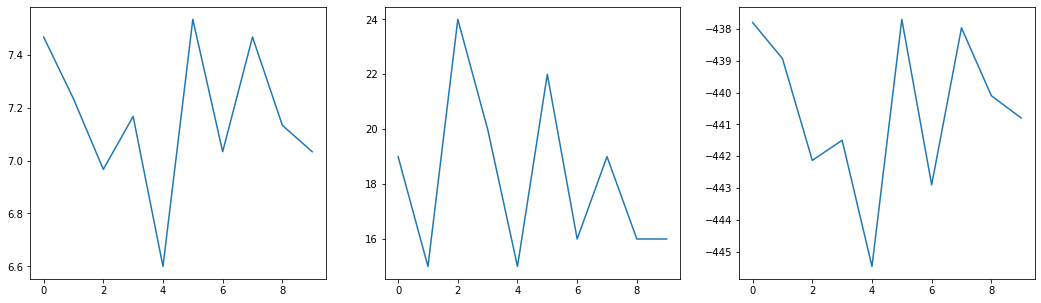

Best Score Gen 9: 16
Total Wins: 0


In [17]:
pop, best_ind = train('smallClassic',maxGen=10, populationSize=30, dist=3, selectionSize=4, 
                      newGenSize=29, mutationRate=0.05, n_games=1)

In [18]:
#graphic show
best_agent = SingleLookAgent(6, create_random_chromossome())
args = readCommand(['--pacman', 'GreedyAgent', '-g', 'DirectionalGhost','-l', 'smallClassic','-n', '1'])
args['pacman'] = best_agent
runGames(**args)

### Treinamento -  Small Classic

Primeiramente vamos fazer o treinamento para o labirinto pequeno, incialmente vamos ver o comprotamento para 100 gerações para diferentes tamanhos de população: 20, 40 e 60, deixando sempre os 5% melhores da população original e selecionando 10% da população para o crossover


73


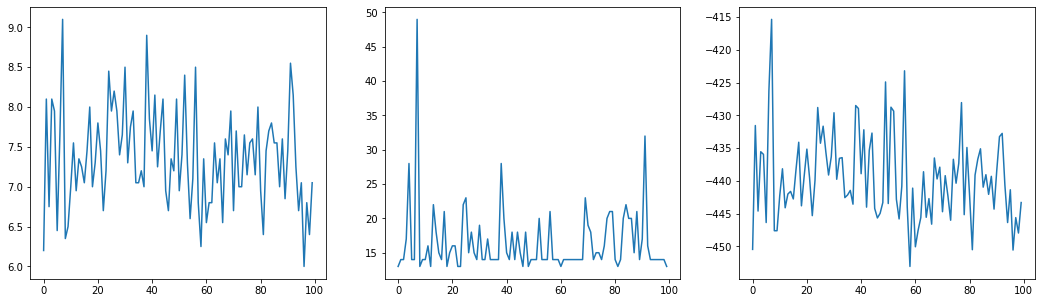

Best Score Gen 99: 13
Total Wins: 0


In [19]:
random.seed(10)
print(random.randrange(90))
pop20, i20 = train('smallClassic',maxGen=100, populationSize=20, dist=3, selectionSize=2, 
                      newGenSize=19, mutationRate=0.05, n_games=1)

73


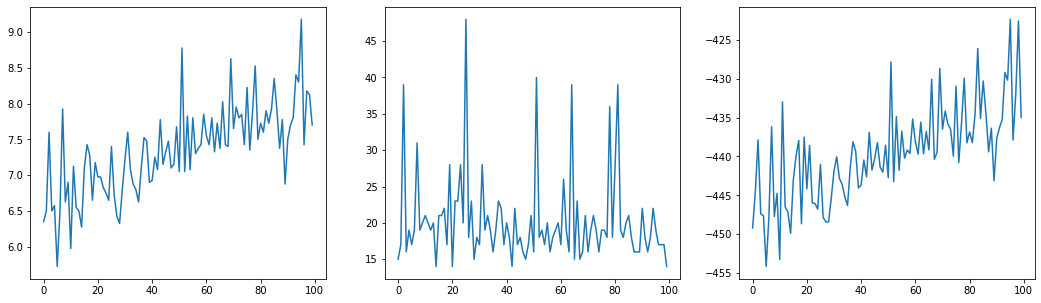

Best Score Gen 99: 14
Total Wins: 0


In [20]:
random.seed(10)
print(random.randrange(90))
pop40, i40 = train('smallClassic',maxGen=100, populationSize=40, dist=3, selectionSize=4, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

73


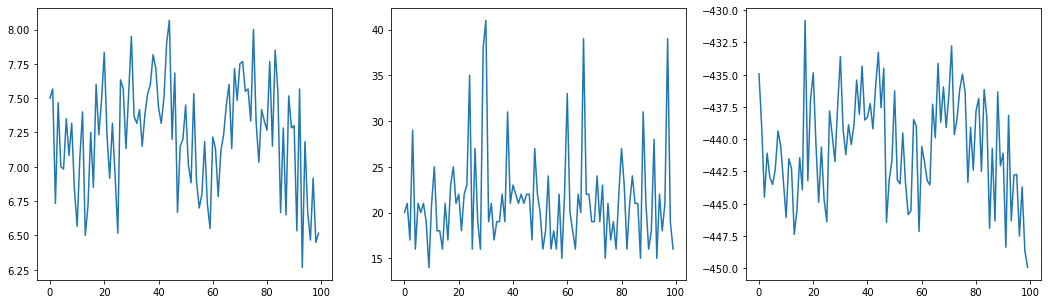

Best Score Gen 99: 16
Total Wins: 0


In [21]:
random.seed(10)
print(random.randrange(90))
pop60, i60 = train('smallClassic',maxGen=100, populationSize=60, dist=3, selectionSize=6, 
                      newGenSize=57, mutationRate=0.05, n_games=1)

Pela rápida comparação que podemos ver das curvas de score e food média as curavas com melhores tendência foi para a população inicial de 40 individuos, alcançando uma média mais alta pelo número de gerações dado. Tendo a população inicial vamos testar diferentes distâncias para o a "zona de perigo" tmb, variando entre 2, 4 e 6

73


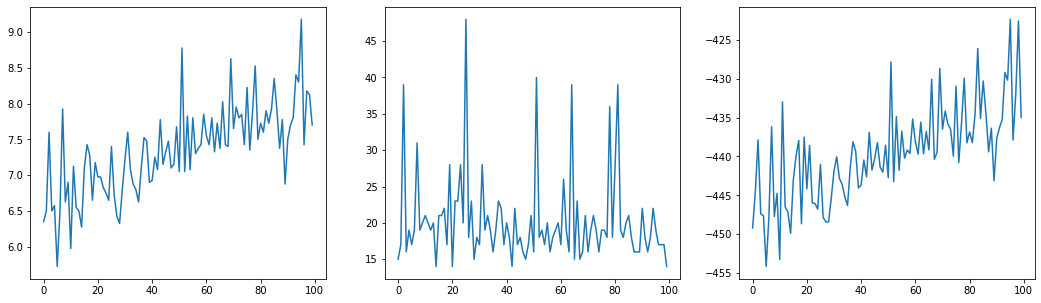

Best Score Gen 99: 14
Total Wins: 0


In [22]:
random.seed(10)
print(random.randrange(90))
pop40, i40 = train('smallClassic',maxGen=100, populationSize=40, dist=2, selectionSize=4, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

73


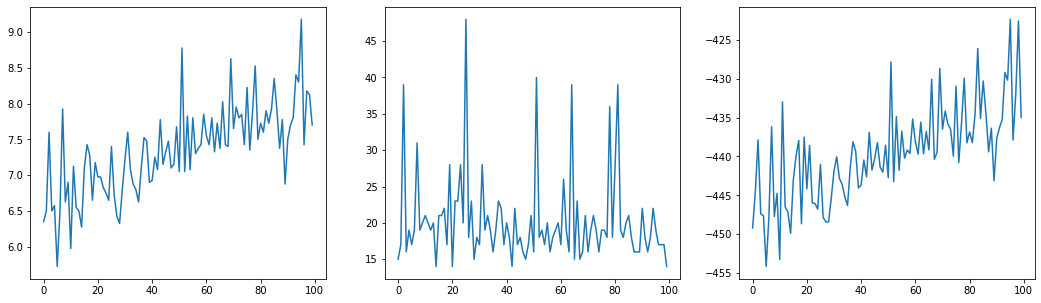

Best Score Gen 99: 14
Total Wins: 0


In [23]:
random.seed(10)
print(random.randrange(90))
pop40, i40 = train('smallClassic',maxGen=100, populationSize=40, dist=4, selectionSize=4, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

73


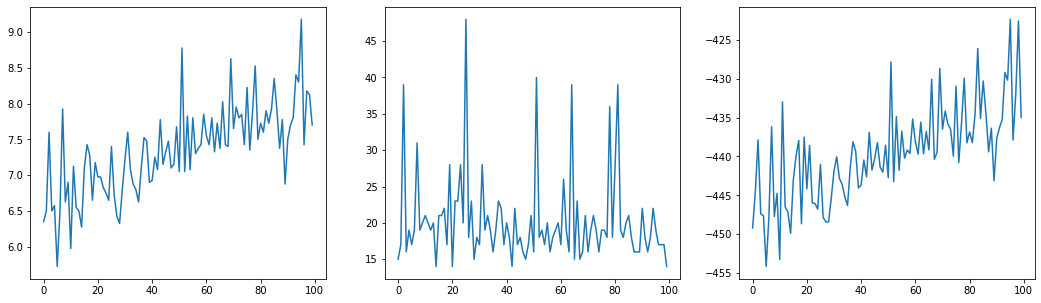

Best Score Gen 99: 14
Total Wins: 0


In [24]:
random.seed(10)
print(random.randrange(90))
pop40, i40 = train('smallClassic',maxGen=100, populationSize=40, dist=6, selectionSize=4, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

Como vimos que a "zona de perigo" afeta pouco os resultados vamos adotar o valor itnermediário de 4. O próximo que testaremos será o número de individuos selecionadas, vamos variar entre 2, 4 e 8 novamente

73


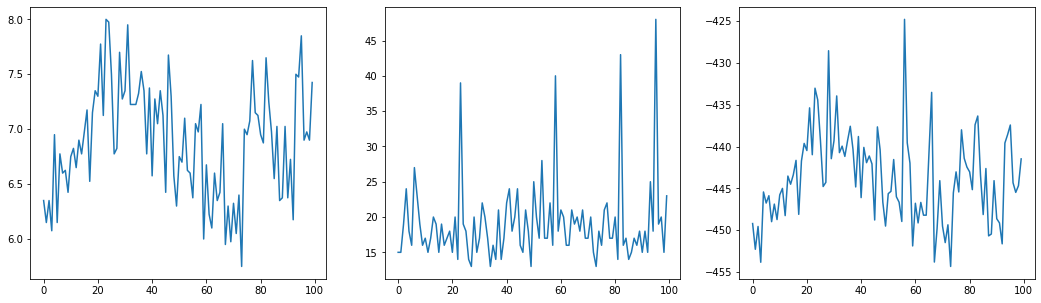

Best Score Gen 99: 23
Total Wins: 0


In [25]:
random.seed(10)
print(random.randrange(90))
pop40, s2 = train('smallClassic',maxGen=100, populationSize=40, dist=6, selectionSize=2, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

73


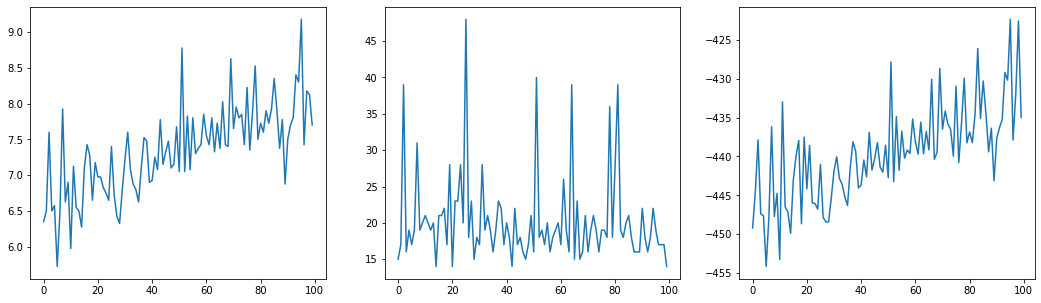

Best Score Gen 99: 14
Total Wins: 0


In [26]:
random.seed(10)
print(random.randrange(90))
pop40, s4 = train('smallClassic',maxGen=100, populationSize=40, dist=6, selectionSize=4, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

73


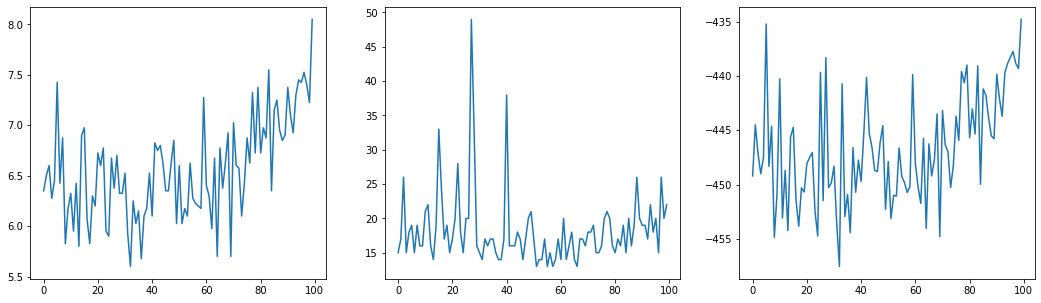

Best Score Gen 99: 22
Total Wins: 0


In [27]:
random.seed(10)
print(random.randrange(90))
pop40, s8 = train('smallClassic',maxGen=100, populationSize=40, dist=6, selectionSize=8, 
                      newGenSize=38, mutationRate=0.05, n_games=1)

Para 4 individuos sendo selecionados a curva se manteve crescente e com resultados promissores, provavelmente devido ao fato de manter a criação das novas gerações somente me função dos melhores mas tendo mais variedado do que para 2. Agora o novo parâmetro a ser testado será o número de individuos novos: para isso vamos testar as diferentes técnicas de replacemente: replacement completo, elitismo,  e replacement parcial

73


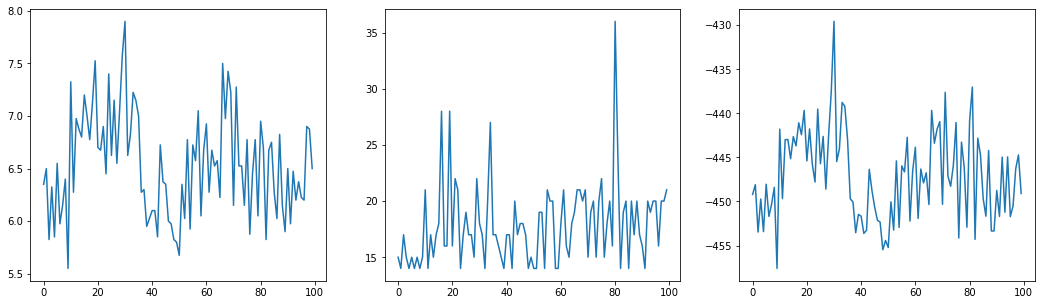

Best Score Gen 99: 21
Total Wins: 0


In [28]:
random.seed(10)
print(random.randrange(90))
pop20, ng0 = train('smallClassic',maxGen=100, populationSize=40, dist=4, selectionSize=4, 
                      newGenSize=40, mutationRate=0.05, n_games=1)

73


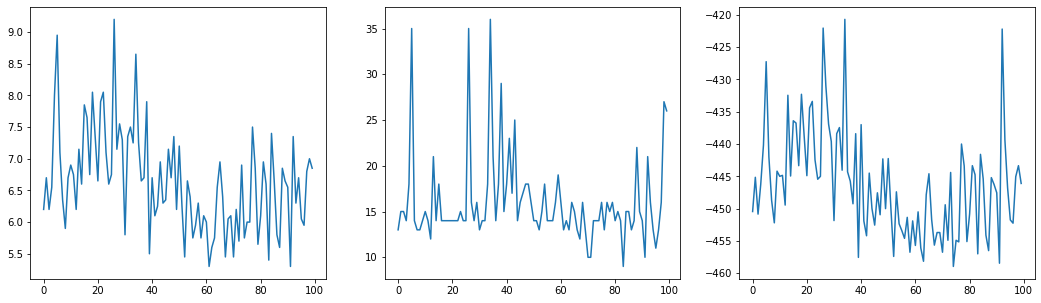

Best Score Gen 99: 26
Total Wins: 0


In [29]:
random.seed(10)
print(random.randrange(90))
pop20, ng1 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=4, 
                      newGenSize=39, mutationRate=0.05, n_games=1)

73


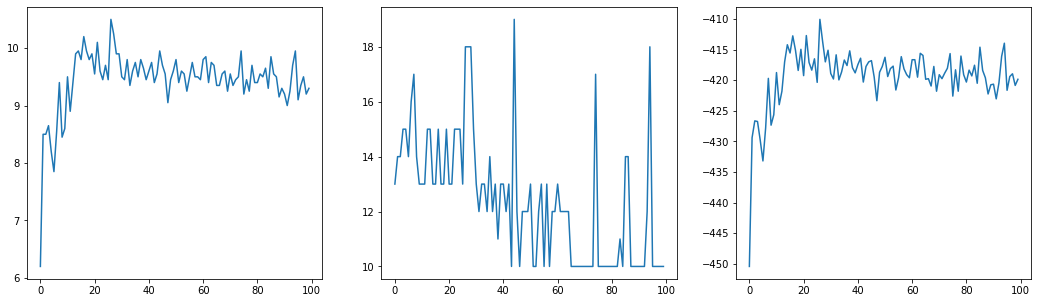

Best Score Gen 99: 10
Total Wins: 0


In [30]:
random.seed(10)
print(random.randrange(90))
pop20, ng3 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.05, n_games=1)

Como podemos ver o replacement parcial teve uma evolução mais rápida que os demais, desta forma seguiremos com ele. Agora vamos mexer com a taxa de mudação, faznedo ela atingir respectivamente 1 (5%), 3(15%) e 5(25%) individuos de cada população

73


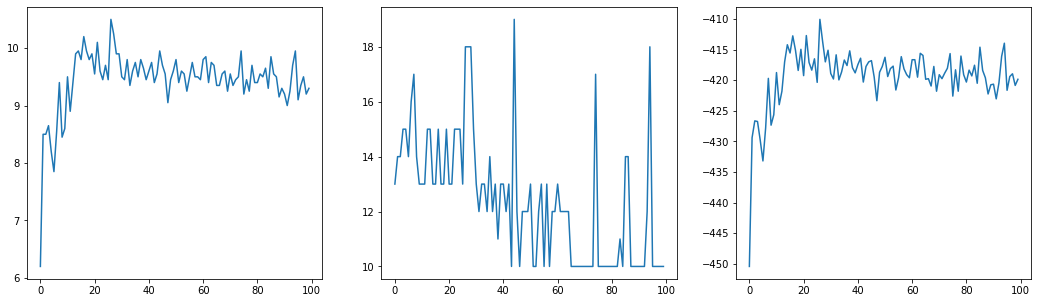

Best Score Gen 99: 10
Total Wins: 0


In [31]:
random.seed(10)
print(random.randrange(90))
pop20, m5 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.05, n_games=1)

73


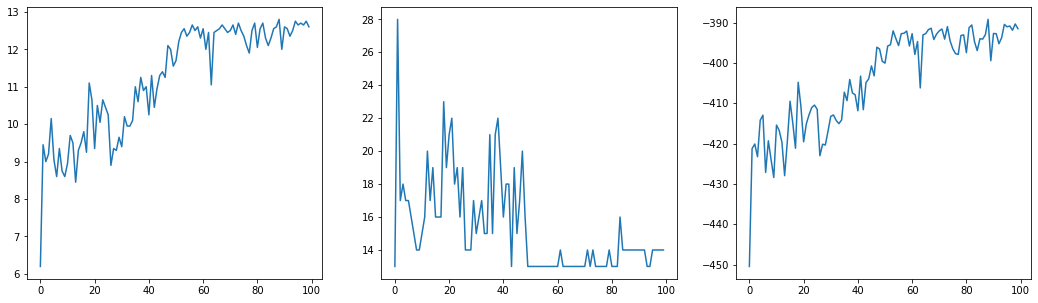

Best Score Gen 99: 14
Total Wins: 0


In [32]:
random.seed(10)
print(random.randrange(90))
pop20, m15 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.15, n_games=1)

73


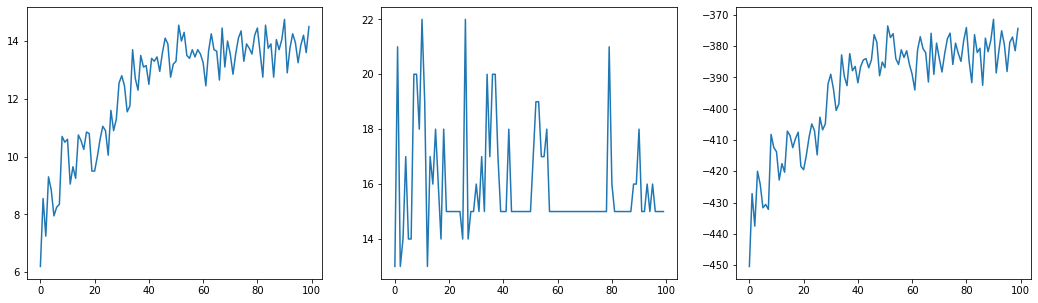

Best Score Gen 99: 15
Total Wins: 0


In [33]:
random.seed(10)
print(random.randrange(90))
pop20, m25 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, n_games=1)

Com resultados de progresso positivo, vamos com a maior taca de mutação. Agora vamos variar a croosover rate, por default ela era colocada em 1, mas vale fazer o teste agora com valores distintos para ver que resultados cosneguimos atingir. Ela será variada entre 1 e 0.75, o que não for crossover na nova geração será elemento duplicado dos individuos selecionadas

73


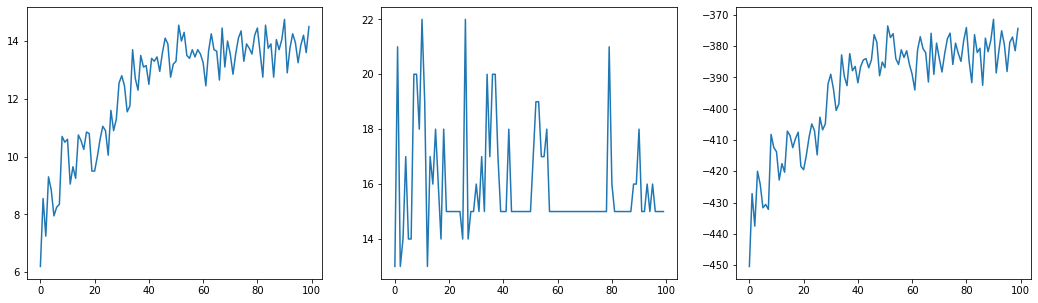

Best Score Gen 99: 15
Total Wins: 0


In [34]:
random.seed(10)
print(random.randrange(90))
pop20, cr1 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 1,n_games=1)

73


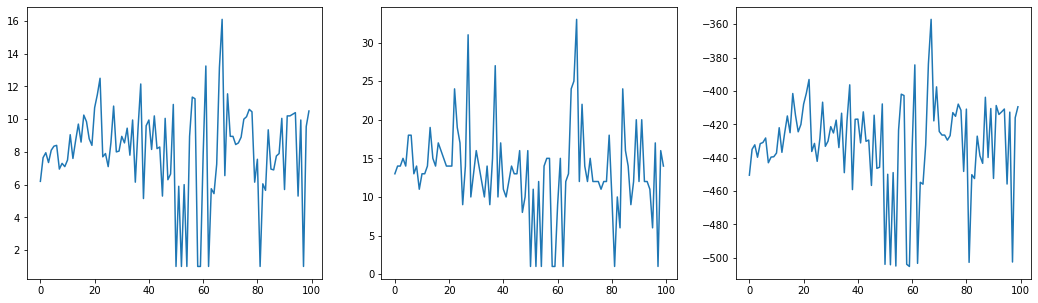

Best Score Gen 99: 14
Total Wins: 0


In [35]:
random.seed(10)
print(random.randrange(90))
pop20, cr9 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 0.9,n_games=1)

73


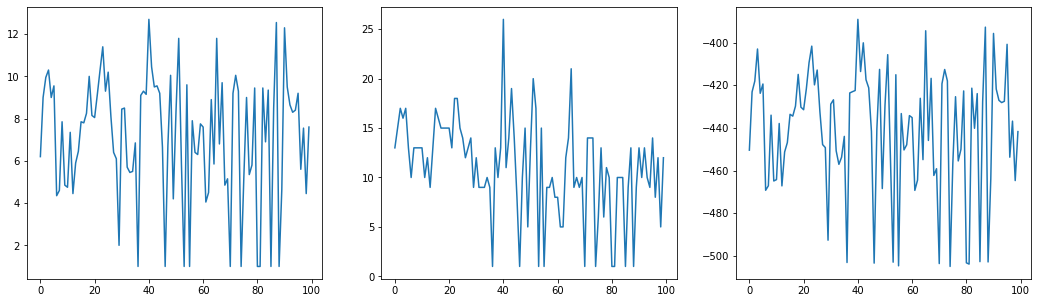

Best Score Gen 99: 12
Total Wins: 0


In [36]:
random.seed(10)
print(random.randrange(90))
pop20, cr75 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 0.75,n_games=1)

Por fim será variado o númro de jogos para a taxa de crossover de 1.0, que teve o melhor desempenho, serão feitos 1, 3 e 5 jogos

73


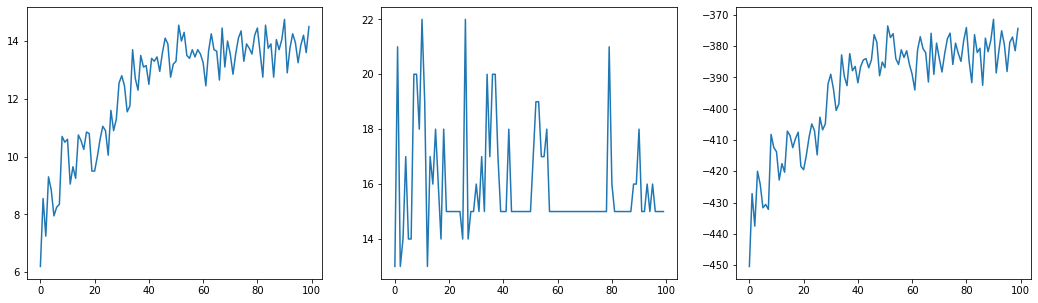

Best Score Gen 99: 15
Total Wins: 0


In [37]:
random.seed(10)
print(random.randrange(90))
pop20, j1 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 1,n_games=1)

73


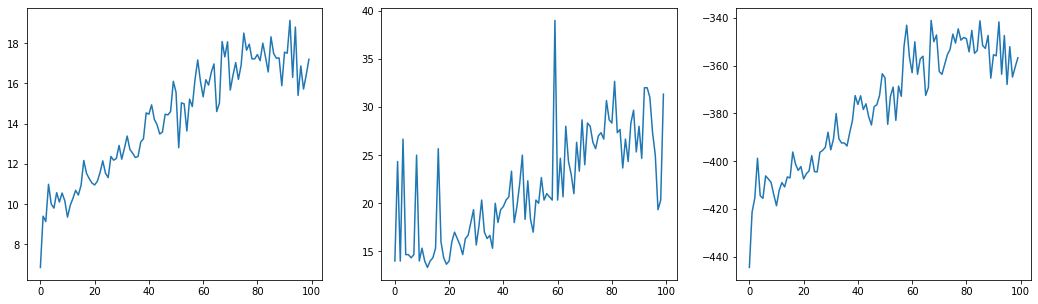

Best Score Gen 99: 31.333333333333332
Total Wins: 0


In [38]:
random.seed(10)
print(random.randrange(90))
pop20, j3 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 1,n_games=3)

73


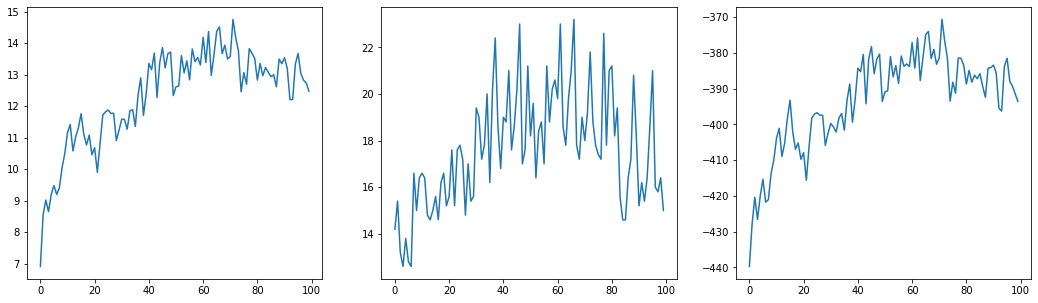

Best Score Gen 99: 15
Total Wins: 0


In [39]:
random.seed(10)
print(random.randrange(90))
pop20, j5 = train('smallClassic',maxGen=100, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 1,n_games=5)

Conforme pudemos ver o melhor resultado foi com 3 jogos, mais lenta mas com uma curva de crescimento mais interessante,  entendo que essa abordagem pode ser prejudicial por conta da baixa proporção dos testes em comparação com o total, podendo favorecer máximos locais ao invés de uma curva de crescimento mais gradual, mas dessa forma ficou clara a visualização das escolhas, ainda que cada uma tivesse um viés da escolha anterior. Agora vamos fazer o treinamento para 30 mil gerações e obter nosso resultado definitivo para 

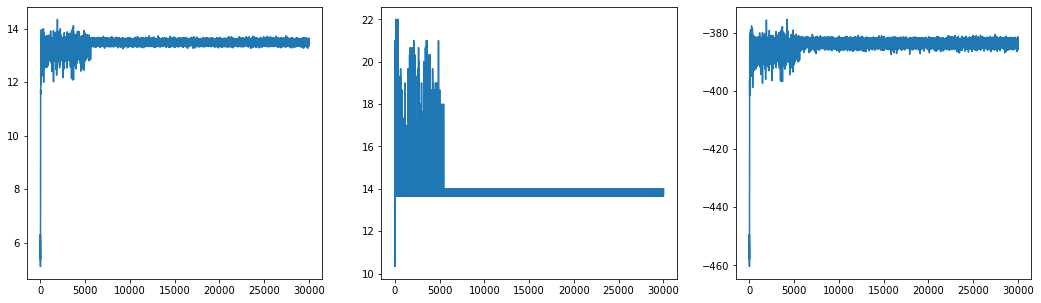

Best Score Gen 29999: 14
Total Wins: 0


In [40]:
pop20, j3 = train('smallClassic',maxGen=30000, populationSize=20, dist=4, selectionSize=40, 
                      newGenSize=36, mutationRate=0.25, crossoverRate = 1,n_games=3)

### Treinamento -  Medium Classic

### Treinamento -  Original Classic

### Avaliação Genetic Programming